In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from google.colab import files

# Load the Food-101 dataset (train and validation)
train_dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)
val_dataset, _ = tfds.load("food101", split="validation", as_supervised=True, with_info=True)

# Get the class names
class_names = info.features['label'].names[:10]  # Select the first 10 classes
num_classes = len(class_names)

# Filter the datasets to keep only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_train_dataset = train_dataset.filter(filter_classes)
filtered_val_dataset = val_dataset.filter(filter_classes)

# Preprocessing function without data augmentation
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalization [0,1]
    return image, label

# Apply preprocessing to both training and validation datasets
train_ds = filtered_train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = filtered_val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [38]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base layers

# Add custom layers for classification
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [39]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Display the model structure
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_20          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
])

Epoch 1/20
    118/Unknown 28s 149ms/step - accuracy: 0.1305 - loss: 2.4564

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 2.21716, saving model to resnet_model.weights.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.1306 - loss: 2.4554 - val_accuracy: 0.1540 - val_loss: 2.2172 - learning_rate: 0.0010
Epoch 2/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1489 - loss: 2.2329
Epoch 2: val_loss improved from 2.21716 to 2.20341, saving model to resnet_model.weights.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.1489 - loss: 2.2328 - val_accuracy: 0.1676 - val_loss: 2.2034 - learning_rate: 0.0010
Epoch 3/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.1669 - loss: 2.2178
Epoch 3: val_loss improved from 2.20341 to 2.19201, saving model to resnet_model.weights.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.1669 - loss: 2.2178 - val_accuracy: 0.1800 - val_loss: 2.1920 - learning_rate: 0.0010
Epoch 4/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1630 - loss: 2.2043
Epoch 4: val_loss improved from

In [46]:
# Download the saved model
files.download('resnet_model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Evaluate the model on the validation dataset
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.2153 - loss: 2.1476

Validation Accuracy: 21.96%

Validation Loss: 2.1388


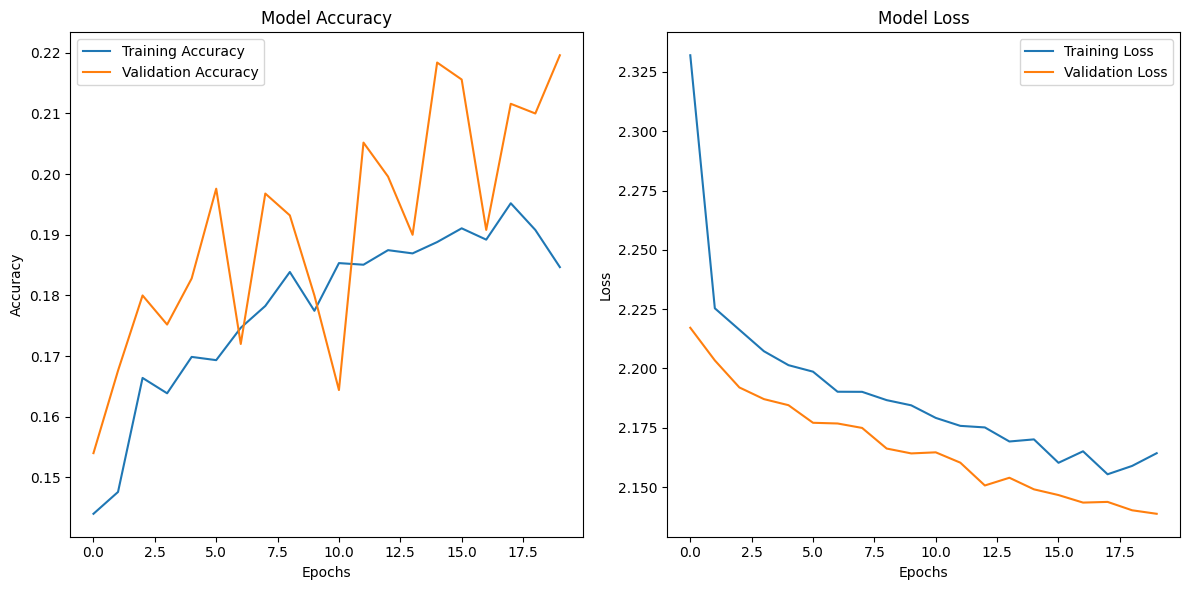

In [48]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report and confusion matrix
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.1739    0.0160    0.0293       250
   baby_back_ribs     0.2820    0.3440    0.3099       250
          baklava     0.2170    0.6840    0.3295       250
   beef_carpaccio     0.2188    0.1400    0.1707       250
     beef_tartare     0.1367    0.2040    0.1637       250
       beet_salad     0.2526    0.4880    0.3329       250
         beignets     0.1871    0.1160    0.1432       250
         bibimbap     0.2583    0.1560    0.1945       250
    bread_pudding     0.2000    0.0200    0.0364       250
breakfast_burrito     0.1892    0.0280    0.0488       250

         accuracy                         0.2196      2500
        macro avg     0.2116    0.2196    0.1759      2500
     weighted avg     0.2116    0.2196    0.1759      2500



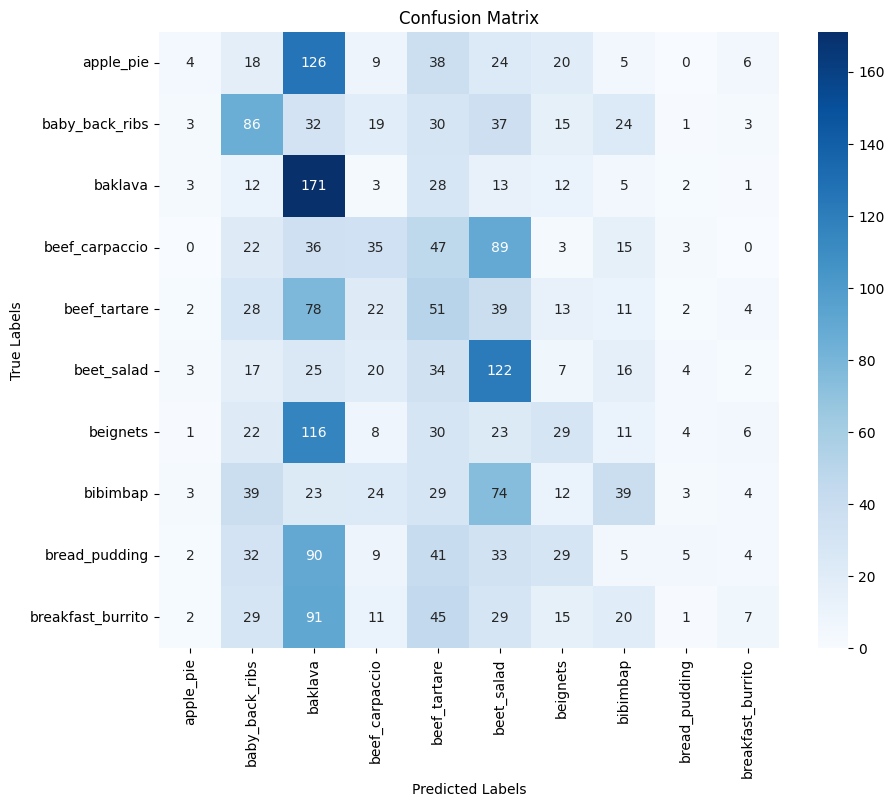

In [50]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()